<a href="https://colab.research.google.com/github/PeterBurton242/WaterTempML/blob/main/WaterTempProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 44007h2019-2023.txt to 44007h2019-2023.txt


In [ ]:
df = pd.read_csv('44007h2019-2023.txt', sep='\s+', low_memory=False)

In [ ]:
df = df[5::]

In [ ]:
df['datetime'] = pd.to_datetime(df[['#YY', 'MM', 'DD', 'hh', 'mm']].rename(columns={'#YY': 'year', 'MM': 'month', 'DD': 'day', 'hh': 'hour', 'mm': 'minute'}))
df = df.set_index('datetime')


<Axes: xlabel='datetime'>

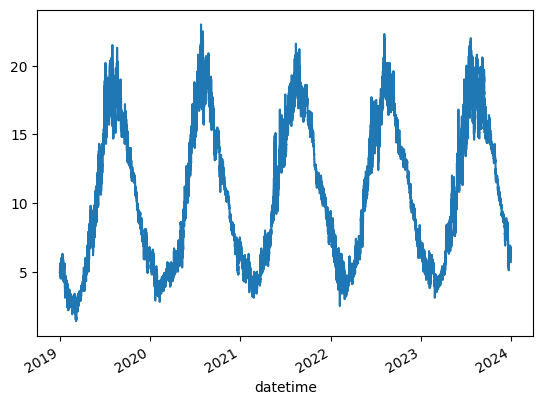

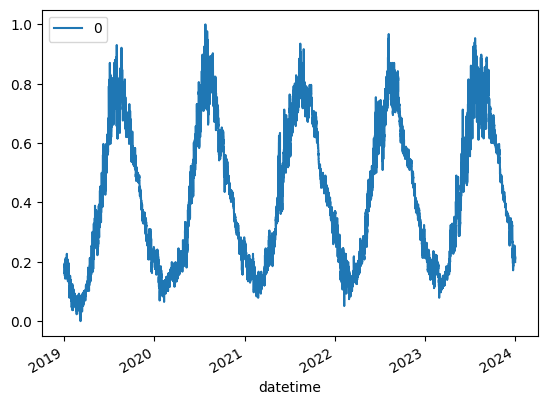

In [ ]:
df = df[df['WTMP'] <= 100]
temp = df['WTMP']
temp.plot()
scalar = MinMaxScaler()
temp = scalar.fit_transform(temp.values.reshape(-1, 1))
temp = pd.DataFrame(temp, index=df.index)
temp.plot()

In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  Xs = []
  ys = []
  for i in range(len(df_as_np)-window_size):
    x = df_as_np[i:i+window_size]
    Xs.append(x)
    y = df_as_np[i+window_size]
    ys.append(y)
  return np.array(Xs), np.array(ys)

In [ ]:
WINDOW_SIZE = 10
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
# X1 = []
# y1 = []
# temp_numpy = temp.to_numpy()
# temp_numpy
# for i in range(len(temp_numpy)):
#   row = [[a] for a in temp_numpy[i:i]]
#   X1.append(row)
#   label = temp_numpy[i]
#   y1.append(label)
# X1 = np.array(X1)
# y1 = np.array(y1)

X1.shape, y1.shape


((180648, 10, 1), (180648, 1))

In [ ]:
X_train, y_train = X1[:100000], y1[:100000]
X_val, y_val = X1[100000:130000], y1[100000:130000]
X_test, y_test = X1[130000:], y1[130000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

NameError: name 'X1' is not defined

In [ ]:
!pip install torch pytorch-lightning pandas scikit-learn matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0003)


In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize model
input_dim = 1 # Number of features
hidden_dim = 128
num_layers = 4
output_dim = 1

model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)

from pytorch_lightning.callbacks import Callback
class TrackTrainLossCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Retrieve the logged train_loss from the current epoch
        train_loss = trainer.logged_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())  # Ensure to convert tensor to Python scalar

    def on_train_end(self, trainer, pl_module):
        # Optionally, do something with the list of train losses when training ends
        print("Training completed. Train losses per epoch:", self.train_losses)

    def on_validation_epoch_end(self, trainer, pl_module):
        # Retrieve the logged val_loss from the current epoch
        val_loss = trainer.logged_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())  # Ensure to convert tensor to Python scalar

my_train_callback = TrackTrainLossCallback()

# Train model
trainer = pl.Trainer(max_epochs=100, callbacks=[my_train_callback],
                     # limit_train_batches=30, limit_val_batches=30, limit_test_batches=30,
                    )
trainer.fit(model, train_loader, val_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params | Mode 
----------------------------------------
0 | lstm | LSTM   | 463 K  | train
1 | fc   | Linear | 129    | train
----------------------------------------
463 K     Trainable params
0         Non-trainable params
463 K     Total params
1.854     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Training completed. Train losses per epoch: [0.000144472491228953, 0.00018384621944278479, 6.312852201517671e-05, 0.0003959041787311435, 2.3804099328117445e-05, 4.271088619134389e-05, 9.902254532789811e-06, 1.1685460776789114e-05, 3.359769834787585e-05, 2.43788817897439e-05, 4.185012585367076e-05, 7.698872650507838e-05, 1.2622256690519862e-05, 3.153658690280281e-05, 7.469273987226188e-05, 3.290189488325268e-05, 1.475110366300214e-05, 6.111162656452507e-05, 2.0477091311477125e-05, 2.564757232903503e-05, 1.7010837837005965e-05, 1.748895192577038e-05, 2.9028560675214976e-05, 3.2398279472545255e-06, 0.0005236135330051184, 1.589130079082679e-05, 2.710789703996852e-05, 2.0702056644950062e-05, 1.2791842891601846e-05, 5.745361704612151e-06, 4.215382068650797e-05, 1.415797396475682e-05, 1.3770963960269e-05, 1.0776790077215992e-05, 1.5107108993106522e-05, 7.335641566896811e-05, 3.1318086257670075e-05, 1.4051027392270043e-05, 7.584534159832401e-06, 4.143173646298237e-05, 2.0689027223852463e-05, 1

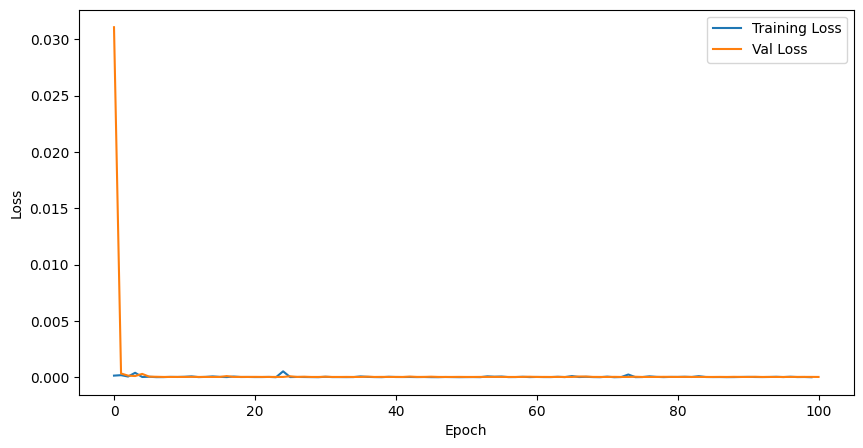

In [ ]:
import matplotlib.pyplot as plt
#def plot_loss(train_loss, val_loss, title, save_path=None, log=False):
# Assuming model is an instance of MyModel and training is done
plt.figure(figsize=(10, 5))
plt.plot(my_train_callback.train_losses, label='Training Loss')
plt.plot(my_train_callback.val_losses, label='Val Loss')
# plt.plot(val_loss, label='Val Loss') #
# plt.plot(np.log2(model.losses), label='log 2 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title(title)
plt.legend()
# plt.savefig(save_path)
plt.show()

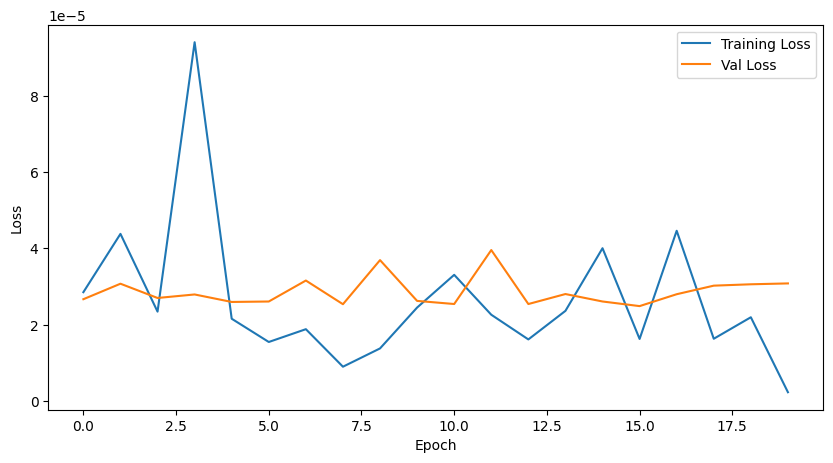

In [ ]:
#def plot_loss(train_loss, val_loss, title, save_path=None, log=False):
# Assuming model is an instance of MyModel and training is done
plt.figure(figsize=(10, 5))
plt.plot(my_train_callback.train_losses[80:100], label='Training Loss')
plt.plot(my_train_callback.val_losses[80:100], label='Val Loss')
# plt.plot(val_loss, label='Val Loss') #
# plt.plot(np.log2(model.losses), label='log 2 Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.title(title)
plt.legend()
# plt.savefig(save_path)
plt.show()

In [ ]:
print(my_train_callback.train_losses[-5:])

[1.622242598386947e-05, 4.461309072212316e-05, 1.627331948839128e-05, 2.1915691831964068e-05, 2.2430444914789405e-06]


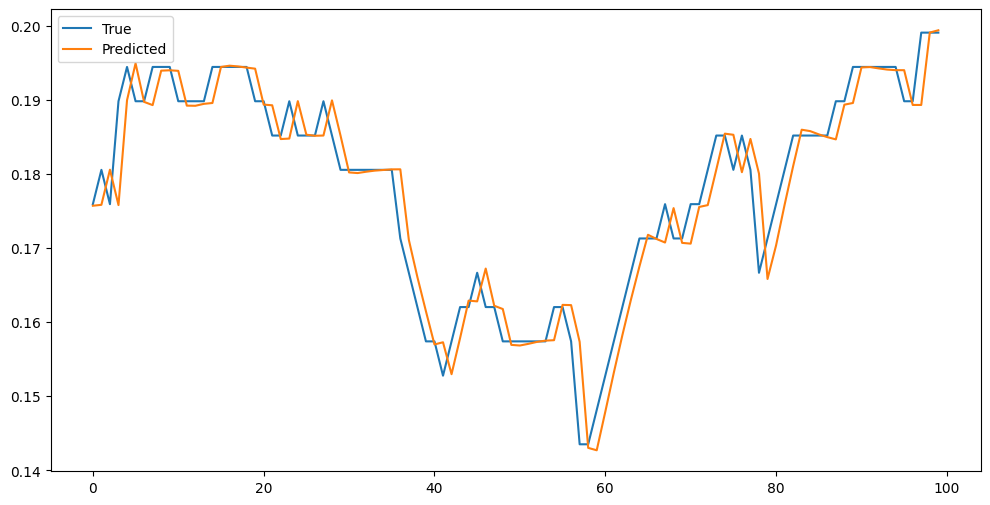

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Predict on the test set
# predictions = trainer.test(model, train_loader)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train[:100], label='True')
plt.plot(model(X_test_tensor[:100]).detach().numpy(), label='Predicted')
plt.legend()
plt.show()

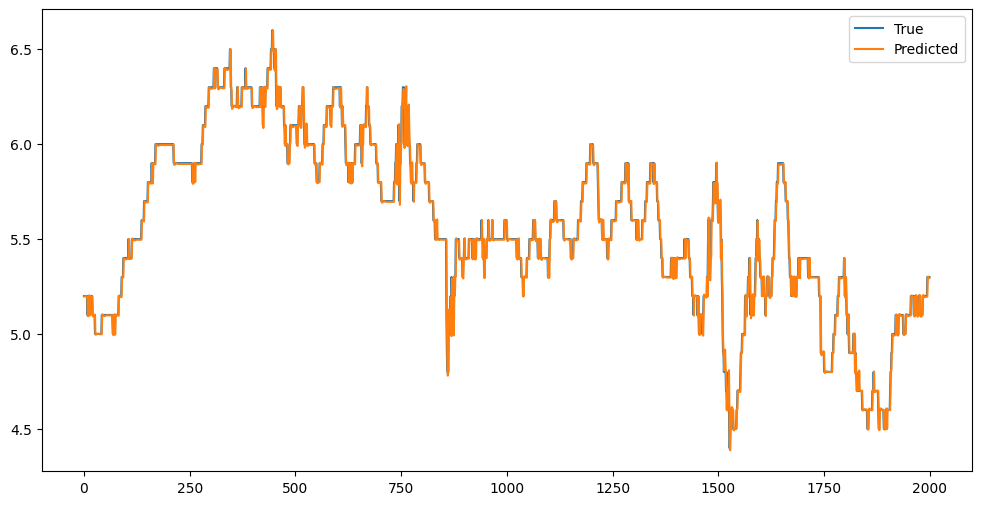

In [ ]:
model.eval()
with torch.no_grad():
  predictions = model(X_test_tensor[:2000]).detach().numpy()
  unscaled_predictions = scalar.inverse_transform(predictions)
  unscaled_y_test = scalar.inverse_transform(y_test)
  plt.figure(figsize=(12, 6))
  plt.plot(unscaled_y_test[:2000], label='True')
  plt.plot(unscaled_predictions, label='Predicted')
  plt.legend()
  plt.show()

In [ ]:
trainer.test(model, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  2.6266994609613903e-05   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.6266994609613903e-05}]